This notebook builds the reference 7–day trajectories dataset (from the "point" test set).

In [ ]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import clouddrift as cd
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
ROOT = Path(".")
DATA_DIR = ROOT / "data"

N_DAYS = 7

In [3]:
from_datetime_str = "1994-06-01"
to_datetime_str = "2025-08-01"

In [4]:
test_ds = xr.open_zarr(DATA_DIR / f"gdp_interp_clean_{from_datetime_str}_{to_datetime_str}_test.zarr")

In [5]:
test_ds = test_ds.sortby(["id", "time"])

In [12]:
def chunk_trajectories(
    ds: xr.Dataset, n_days: int = N_DAYS, dt: np.timedelta64 = np.timedelta64(1, "h"), to_ragged: bool = False
) -> xr.Dataset:
    def ragged_chunk(arr: xr.DataArray | np.ndarray, is_metadata: bool = False) -> np.ndarray:
        arr = cd.ragged.apply_ragged(cd.ragged.chunk, arr, rowsize, chunk_size)  # noqa
        if is_metadata:
            arr = arr[:, 0]
        if to_ragged:
            arr = arr.ravel()
        return arr

    _, idx, rowsize = np.unique(test_ds.id, return_index=True, return_counts=True)
    rowsize = rowsize[np.argsort(idx)]

    rowsize = cd.ragged.segment(ds.time, dt, rowsize)  # if holes, divide into segments
    chunk_size = int(n_days / (dt / np.timedelta64(1, "D"))) + 1

    data = dict(
        [(d, (("traj", "obs"), ragged_chunk(ds[d]))) for d in ["id", "time", "lat", "lon"]]
    )

    ds = xr.Dataset(data_vars=data)

    return ds

In [13]:
traj_ds = chunk_trajectories(test_ds)

In [46]:
traj_ds

<xarray.Dataset> Size: 315MB
Dimensions:  (traj: 77633, obs: 169)
Dimensions without coordinates: traj, obs
Data variables:
    id       (traj, obs) float64 105MB 3.276e+03 3.276e+03 ... 3.005e+14
    time     (traj, obs) datetime64[ns] 105MB 2001-01-10T14:00:00 ... 2021-10...
    lat      (traj, obs) float32 52MB -65.56 -65.56 -65.55 ... 45.27 45.28 45.29
    lon      (traj, obs) float32 52MB -179.2 -179.2 -179.2 ... -33.07 -33.08

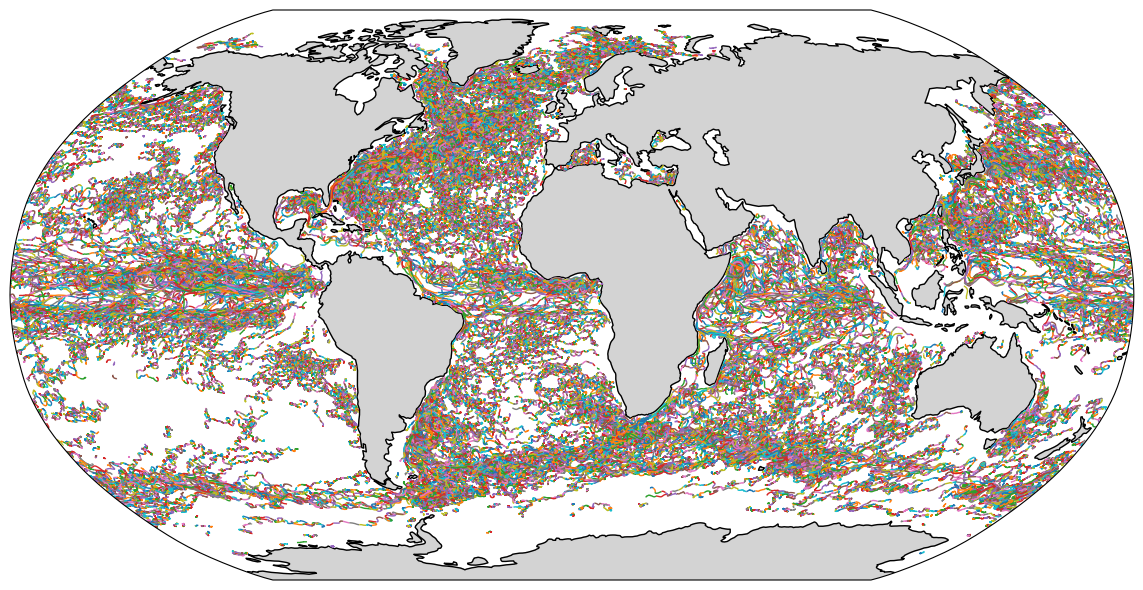

In [44]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.Robinson()})

segs = np.stack([traj_ds.lon, traj_ds.lat], axis=-1)
c = [colors.to_rgba(c) for c in plt.rcParams["axes.prop_cycle"].by_key()["color"]]

ax.add_collection(LineCollection(segs, colors=c, linewidths=(1,), transform=ccrs.PlateCarree()))

ax.coastlines()
ax.set_global()
ax.add_feature(cfeature.LAND, color="lightgrey")

fig.tight_layout()

plt.show()

In [45]:
traj_ds.to_zarr(DATA_DIR / f"gdp_interp_clean_{from_datetime_str}_{to_datetime_str}_test_traj.zarr", mode="w")

/home/bertrava/.local/share/mamba/envs/pastax_global_calibration/lib/python3.11/site-packages/zarr/api/asynchronous.py:247: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
